In [2]:
import numpy as np
import random
import os
import copy

class GA:
    # Setting=[Name, MaxGeneration, Population, EliteCount, MaxStagnationGeneration, GenesDimension ...]
    def __init__(self, Setting):
        self.Name = Setting[0]
        self.MaxGeneration = Setting[1]
        self.Population = Setting[2]
        self.EliteCount = Setting[3]
        self.MaxStagnationGeneration = Setting[4]
        self.GenesDimension = Setting[5]

        os.makedirs("./Out/", exist_ok=True)

        print("\n GA start!! \n")


        # flag==0、print出力 flag==1、ファイル記述
    def get_parameter(self, flag=0, out_path="./"):
        # ファイル出力の際のパス
        out_path = out_path + "GA_parameter.txt"
        # 出力内容
        contents = [
                     f'GA_parameter!!\n',
                     f'Name: {self.Name}',
                     f'MaxGeneration: {self.MaxGeneration}',
                     f'Population: {self.Population}',
                     f'EliteCount: {self.EliteCount}',
                     f'GenesDimension: {self.GenesDimension}',
                                                                ]
        # flagにより出力先を変更
        if flag==0:
            for sentense in contents:
                print(sentense)
        elif flag==1:
            with open(out_path, mode="w") as file:
                for sentense in contents:
                    print(sentense, file=file)


    # GAを始める関数（というか、この中に処理ほとんど書いてるからmain関数みたいなもの？）
    def Start_GA(self):
        # 現在の世代
        generation = 0
        # 世代の停滞値
        Stagnation = 0
        # 目標値
        goal = 0
        # 一番適応度の良い遺伝子の軌跡
        top_genes = list()
        # 初期集団として遺伝子をランダムに作成。
        genes = self.make_genes()
        while(True):
            #　最大世代まで進むと終了
            if generation >= self.MaxGeneration:
                break
            else:
                # 適応度の評価
                evaluated_data = self.evaluate(genes, goal)
                # 遺伝子ファイルと適応度を外部に出力
                self.Out_data(genes, evaluated_data, generation)
                # 適応度の高い上位個体を保存
                elite_genes = copy.deepcopy(self.Save_elite(genes, evaluated_data))
                # 適応度の高い者同士を選択
                Select_id = self.select(0, genes, evaluated_data)
                # 交叉させて新しい遺伝子の作成
                genes = self.crossover(0, genes, Select_id)
                # 突然変異を与えて解探索領域を広げる
                genes = self.mutation(genes, Stagnation)
                # エリート遺伝子を加える
                genes[len(genes):len(genes)] = elite_genes
                # 一番適応度の良い個体を保存
                top_genes.append(elite_genes[0])
                # 第二世代以降において、適応度の停滞（適応度の一番良い値が更新されない）が最大停滞数を超えていればプログラムは終了。
                if len(top_genes)>=2:
                    if top_genes[-1]==top_genes[-2]:
                        # 最大停滞数を超えればアルゴリズムは終了
                        if Stagnation >= self.MaxStagnationGeneration:
                            exit()
                        else:
                            Stagnation += 1
                    else:
                        Stagnation = 0
                # 世代を進める
                generation +=1



    # 遺伝子をランダムに作成。一つの個体に対してself.GenesDimensionの数だけ次元を広げる
    def make_genes(self):
        genes = list()
        tmp = list()
        for child in range(self.Population):
            for _ in range(self.GenesDimension):
                tmp.append(random.randint(-30,30))
            genes.append(tmp)
            tmp = list()
        # genes.shape=(self.Population, self.GenesDimension)
        return genes



    # 遺伝子の評価
    def evaluate(self, genes, goal):
        # 評価したデータは辞書型で保持。(key, value)=(child_id, fitness)
        evaluated_data = dict()
        for child in range(self.Population):
            # 適応度は高い方がよい（最大で1となるように調整。)
            fitness = 1/(self.eval_func(genes[child], goal) + 1)
            evaluated_data[child] = fitness
        # 評価値に沿って降順ソート
        evaluated_data = dict(sorted(evaluated_data.items(),reverse=True, key=lambda x:x[1]))
        return evaluated_data

    # evaluateの補助関数
    # 目標値との差分を計算
    def eval_func(self, gene, goal):
        sum_value = 0
        # self.GenesDimension空間における原点からのユークリッド距離を計算。
        for id in range(len(gene)):
            sum_value += gene[id]**2
        return abs(np.sqrt(sum_value) - goal)   # goal(目標値)とのずれを計算。


    # genesデータや適応度などを外部ファイルに出力
    def Out_data(self, genes, evaluated_data, generation):
        # 遺伝子の出力(並び替え前), csvと同じカンマ区切り
        gene_path = "./Out/" + str(generation) + ".gene"
        with open(gene_path, "w") as file:
            for child in range(len(genes)):
                for id in range(len(genes[child])):
                    if id==len(genes[child])-1:
                        print(str(genes[child][id]), file=file)
                    else:
                        print(str(genes[child][id]), end=",", file=file)
        # 適応度の出力（並び替え後）,csvと同じカンマ区切り
        fitness_path = "./Out/" + str(generation) + ".fit"
        with open(fitness_path, "w") as file:
            for id, fitness in evaluated_data.items():
                print(str(id) +","+ str(fitness), file=file)


    # 適応度の高い上位個体を保存
    def Save_elite(self, genes, evaluated_data):
        elite_id = list()
        elite_genes = list()
        # elite_idを辞書から取得
        for key in evaluated_data.keys():
            elite_id.append(key)
        # eliteの数だけ上から抽出
        for elite in range(self.EliteCount):
            elite_genes.append(genes[elite_id[elite]])

        return elite_genes




    # method==0: Expected value selection
    # method==1: Ranking selection
    # method==2: Tournament selection
    def select(self, method, genes, evaluated_data):
        # idとfitnessを個別にリストで保管
        id_list = list()
        fitness_list = list()
        Select_id = list()
        for id, fitness in evaluated_data.items():
            id_list.append(id)
            fitness_list.append(fitness)

        # 期待値選択
        if method==0:
            roulette = 360
            tmp_list = list()
            sum_fitness = sum(fitness_list) # 適応度の合計値を取得
            cumulative_fitness = np.cumsum(roulette*np.array(fitness_list)/sum_fitness) # 適応度の高さに応じて幅の広い一回転360度のテーブルを作成
            for child in range(self.Population - self.EliteCount):    # エリート以外の個体を作成するため、個体数 ー エリート個体数
                for _ in range(2):                                    # ２つの遺伝子を組み合わせるため繰り返す。
                    Fate_dice = random.uniform(0,360)                 # 0~360の間の運命のサイコロを振る
                    Hit_id = 0
                    while True:
                        if cumulative_fitness[Hit_id] >= Fate_dice:
                            break
                        else:
                            Hit_id += 1
                    tmp_list.append(id_list[Hit_id])
                Select_id.append(tmp_list)
                tmp_list = list()
        return Select_id



    # method==0: Uniform crossover
    # method==1: Multipoint crossover
    # method==2: Partial coincidence crossover
    def crossover(self, method, genes, Select_id):
        new_genes = list()
        # 次の世代のgenesをSelect_id[child][0]のid番号を使って作成
        for child in range(self.Population - self.EliteCount):
            new_genes.append(genes[Select_id[child][0]])

        if method==0:
            probability = 0.4
            for child in range(self.Population - self.EliteCount):
                for dim in range(len(genes[0])):
                    Fate_random = random.uniform(0,1)
                    if Fate_random <= probability:
                        new_genes[child][dim] = genes[Select_id[child][1]][dim]
        return new_genes



    def mutation(self, genes, Stagnation):
        probability = 0.4                          #突然変異をする確率
        serious_rate = Stagnation/(self.MaxGeneration - self.EliteCount)   # 停滞が大きくなれば突然変異する可能性も上げる
        serious_count = int(len(genes)*serious_rate)        # genes配列の大きさを掛けることで、配列のどこまでを突然変異与えるのか調整
        for child in range(serious_count):
            for dim in range(len(genes[0])):
                Fate_random = random.uniform(0,1)      # 0~1の乱数を取得
                if Fate_random <= probability:
                    genes[child][dim] += random.randint(-10,10) # -10~10の乱数を付与（決め打ち）
        return genes


# Setting=[Name, MaxGeneration, Population, EliteCount, MaxStagnationGeneration, GenesDimension ...]
Setting = ["Sample", 150, 30, 2, 100, 3]
GA = GA(Setting)
GA.Start_GA()




 GA start!! 



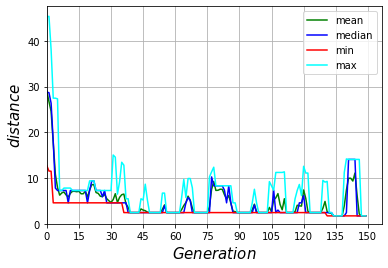

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# データフレームから距離を計算
def calc_distance(dataframe):
    distance = 0
    for col in range(len(dataframe.columns)):   # 列の数だけ繰り返す
        distance += dataframe[col]**2
    distance = np.sqrt(distance) # ユークリッド距離を計算
    return distance

# データフレームの結合
def merge_dataframe(origin, add):
    origin = pd.concat([origin, add], axis=1)
    return origin

# 時系列データとしてグラフを作成
def plot_log(distance, MaxGeneration):
    y_mean = np.array(distance.mean())      # データの平均値を取得
    y_median = np.array(distance.median())  # 中央値を取得
    y_min = np.array(distance.min()) # 最小値を取得
    y_max = np.array(distance.max()) # 最大値を取得
    x = np.arange(len(y_mean))
    xicks = np.arange(0, MaxGeneration+1, MaxGeneration/10)   # MaxGenerationもメモリに表示させるために+1
    plt.plot(x, y_mean, label="mean", color="green")
    plt.plot(x, y_median,label="median", color="blue")
    plt.plot(x, y_min, label="min", color="red")
    plt.plot(x, y_max, label="max", color="cyan")
    plt.xlabel("$Generation$", fontsize=15)
    plt.ylabel("$distance$", fontsize=15)
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.grid(True)
    plt.xticks(xicks)
    plt.legend()
    plt.savefig("analysis_gene.jpg")



MaxGeneration = 150

for G in range(MaxGeneration):
    if G==0:
        gene_path = "./Out/" + str(G) + ".gene"
        dataframe_0 = pd.read_csv(gene_path, header=None)  # データの読み取り
        distance_0 = calc_distance(dataframe_0)            # データフレームから距離を計算
    else:
        gene_path = "./Out/" + str(G) + ".gene"
        dataframe = pd.read_csv(gene_path, header=None)
        distance = calc_distance(dataframe)
        distance_0 = merge_dataframe(distance_0, distance)

plot_log(distance_0, MaxGeneration)


